<a href="https://colab.research.google.com/github/sumukhig/ds5500-capstone-project/blob/main/src/notebooks/recognize_symbols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emnist

In [ ]:
from emnist import extract_training_samples, extract_test_samples, inspect
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import cv2

import timeit
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o -q /content/drive/MyDrive/DS5500/datasets/cls_dataset.zip

In [ ]:
!mkdir /content/hasyv2

In [ ]:
!unzip -o -q /content/drive/MyDrive/DS5500/datasets/hasyv2.zip -d /content/hasyv2

In [ ]:
!cp /content/drive/MyDrive/DS5500/datasets/class_mapping.txt /content

In [ ]:
x_train_emnist, y_train_emnist = extract_training_samples("balanced")
x_test_emnist, y_test_emnist = extract_test_samples("balanced")

In [ ]:
emnist_class_labels = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

In [ ]:
offhme_data_path = './cls_dataset'

In [ ]:
class_map = {}
with open('./class_mapping.txt', 'r') as f:
  map = f.readlines()

  for line in map:
    key = line.split(':')[0]
    value = line.split(':')[1].strip()
    if value == "COMMA":
      value = ","
    class_map[value] = int(key)
  f.close()

inverted_map = {v: k for k, v in class_map.items()}

In [ ]:
df_hasy_data = pd.read_csv('./hasyv2/hasy-data-labels.csv')

In [ ]:
# Load training data
x_train = []
y_train = []
num_classes = len(class_map)

for folder in glob.glob(offhme_data_path + '/train/*'):
  cls = folder.split('/')[-1]
  if cls == "COMMA":
      cls = ","
  cls_vector = np.zeros(num_classes)
  cls_vector[class_map[cls]] = 1

  if cls.isalnum():
    try:
      cls_emnist = list(emnist_class_labels.keys())[list(emnist_class_labels.values()).index(cls)]
    except:
      cls_emnist = list(emnist_class_labels.keys())[list(emnist_class_labels.values()).index(cls.upper())]
    idx_emnist = [i for i in range(len(y_train_emnist)) if y_train_emnist[i] == cls_emnist]
    for i in idx_emnist:
      img_emnist = x_train_emnist[i]
      img_transformed = cv2.normalize(img_emnist, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      img_transformed = cv2.resize(img_transformed, (32,32))
      x_train.append(img_transformed)
      y_train.append(cls_vector)
  else:
    for path in df_hasy_data[df_hasy_data["latex"] == cls]["path"]:
      img_hasy = cv2.imread('./hasyv2/' + path)
      img_transformed = cv2.resize(img, (32,32))
      img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2GRAY)
      img_transformed = cv2.normalize(img_transformed, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      x_train.append(img_transformed)
      y_train.append(cls_vector)

  for file in glob.glob(folder.replace('*', cls) + '/*'):
    img = cv2.imread(file)
    img_transformed = cv2.resize(img, (32,32))
    img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2GRAY)
    img_transformed = cv2.normalize(img_transformed, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    x_train.append(img_transformed)
    y_train.append(cls_vector)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
# Load validation data
x_val = []
y_val = []
num_classes = len(class_map)

for folder in glob.glob(offhme_data_path + '/val/*'):
  cls = folder.split('/')[-1]
  if cls == "COMMA":
    cls = ","
  cls_vector = np.zeros(num_classes)
  cls_vector[class_map[cls]] = 1

  for file in glob.glob(folder.replace('*', cls) + '/*'):
    img = cv2.imread(file)
    img_transformed = cv2.resize(img, (32,32))
    img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2GRAY)
    img_transformed = cv2.normalize(img_transformed, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    x_val.append(img_transformed)
    y_val.append(cls_vector)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
# Load test data
x_test = []
y_test = []
num_classes = len(class_map)

for folder in glob.glob(offhme_data_path + '/test/*'):
  cls = folder.split('/')[-1]
  if cls == "COMMA":
    cls = ","
  cls_vector = np.zeros(num_classes)
  cls_vector[class_map[cls]] = 1

  for file in glob.glob(folder.replace('*', cls) + '/*'):
    img = cv2.imread(file)
    img_transformed = cv2.resize(img, (32,32))
    img_transformed = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2GRAY)
    img_transformed = cv2.normalize(img_transformed, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    x_test.append(img_transformed)
    y_test.append(cls_vector)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype("float32")
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1).astype("float32")
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype("float32")

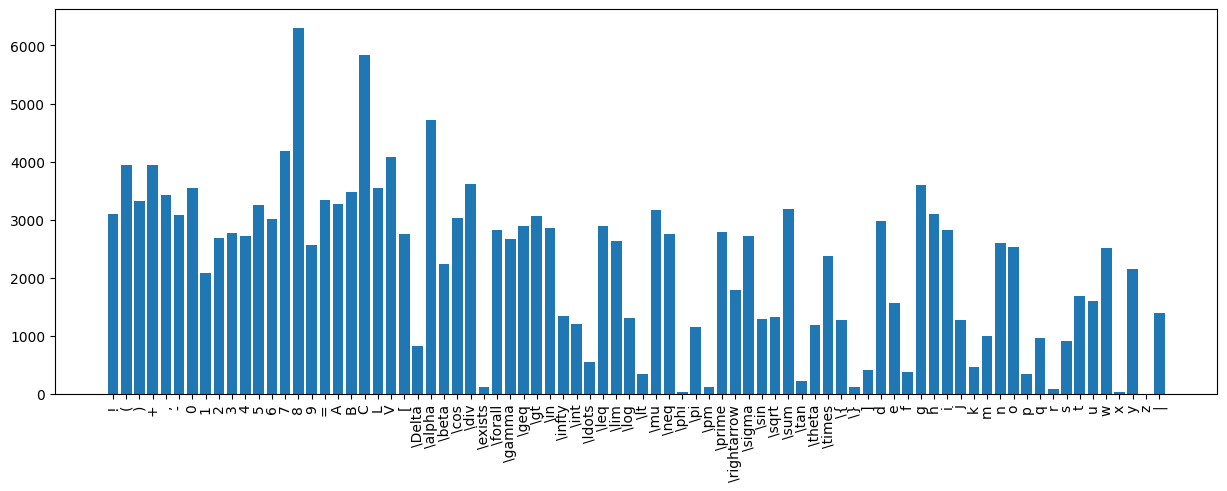

In [ ]:
# Class distribution
plt.figure(figsize=(15,5))
plt.bar(np.unique([inverted_map[i] for i in np.argmax(y_train, axis=1)]), np.unique(np.argmax(y_train, axis=1), return_counts=True)[1])
plt.xticks(rotation=90)
plt.show()

In [ ]:
def create_lenet5_model():
# Creating CNN model with LeNet-5 architecture
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=6, kernel_size=(5,5), padding='same',
                       activation=tf.nn.relu, input_shape = (32,32,1))) # C1

    model.add(layers.MaxPool2D(pool_size=(2,2), strides = (2,2))) # S2

    model.add(layers.Conv2D(filters=16, kernel_size=(5,5), padding='same',
                       activation=tf.nn.relu)) # C3

    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2))) # S4

    model.add(layers.Flatten())
    model.add(layers.Dense(120,activation=tf.nn.relu)) # C5
    model.add(layers.Dense(84,activation=tf.nn.relu)) # F6
    model.add(layers.Dense(100,activation=tf.nn.softmax)) # F7

    opt = tf.keras.optimizers.experimental.RMSprop()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
lenet5_model = create_lenet5_model()

In [ ]:
b_size = 200
n_epochs = 10

start_time = time.time()

history = lenet5_model.fit(x_train, y_train, batch_size = b_size, epochs= n_epochs, verbose= 2, validation_data=(x_val, y_val))

elapsed_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Epoch 1/10
899/899 - 151s - loss: 0.9555 - accuracy: 0.7439 - val_loss: 2.5597 - val_accuracy: 0.7322 - 151s/epoch - 168ms/step
Epoch 2/10
899/899 - 151s - loss: 0.3735 - accuracy: 0.8797 - val_loss: 2.3053 - val_accuracy: 0.7882 - 151s/epoch - 168ms/step
Epoch 3/10
899/899 - 149s - loss: 0.3015 - accuracy: 0.8997 - val_loss: 2.2409 - val_accuracy: 0.7992 - 149s/epoch - 166ms/step
Epoch 4/10
899/899 - 150s - loss: 0.2651 - accuracy: 0.9105 - val_loss: 2.1527 - val_accuracy: 0.7733 - 150s/epoch - 167ms/step
Epoch 5/10
899/899 - 148s - loss: 0.2411 - accuracy: 0.9170 - val_loss: 2.1282 - val_accuracy: 0.8056 - 148s/epoch - 165ms/step
Epoch 6/10
899/899 - 153s - loss: 0.2240 - accuracy: 0.9212 - val_loss: 2.2511 - val_accuracy: 0.8100 - 153s/epoch - 170ms/step
Epoch 7/10
899/899 - 150s - loss: 0.2094 - accuracy: 0.9263 - val_loss: 2.2205 - val_accuracy: 0.8083 - 150s/epoch - 167ms/step
Epoch 8/10
899/899 - 148s - loss: 0.1974 - accuracy: 0.9295 - val_loss: 2.2446 - val_accuracy: 0.8139 - 

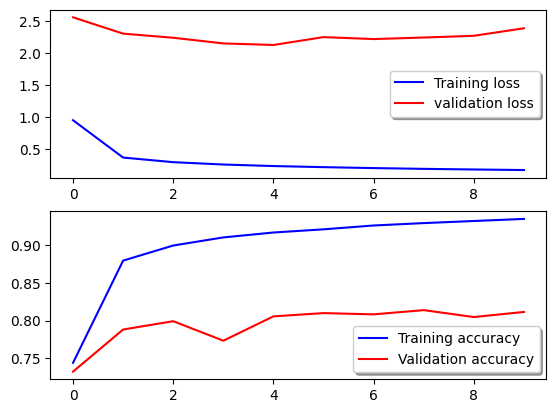

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
y_pred = lenet5_model.predict(x_test)

y_act_classes = np.argmax(y_test,axis = 1)
y_pred_classes = np.argmax(y_pred, axis = 1)

confusion_matrix(y_act_classes, y_pred_classes)

409/409 [==============================] - 6s 13ms/step


array([[196,   0,   1, ...,   0,   0,   0],
       [  0, 775,   0, ...,   0,   0,   0],
       [  1,   0, 345, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   7,   0,   0],
       [  0,   0,   0, ...,   0,   1,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [ ]:
lenet5_model.evaluate(x_test, y_test)

409/409 [==============================] - 6s 14ms/step - loss: 1.9289 - accuracy: 0.8420


[1.9288678169250488, 0.8420004844665527]

In [ ]:
[inverted_map[y] for y in y_act_classes][0:10]

['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']

In [ ]:
[inverted_map[y] for y in y_pred_classes][0:10]

['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']

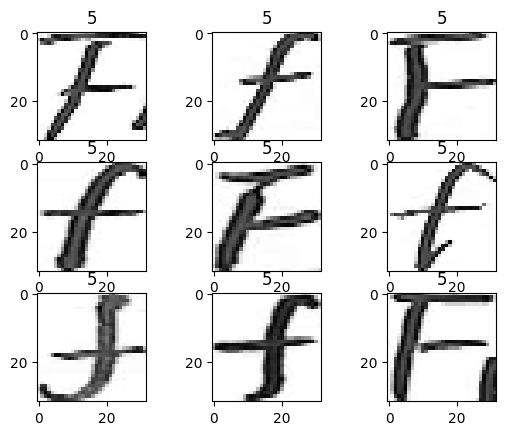

In [ ]:
for i in range(9):
    plt.subplot(int('33' + str(i+1)))
    plt.imshow(x_test[i], cmap = plt.get_cmap('gray'))
    plt.title(np.argmax(y_test[i]))

In [ ]:
lenet5_model.save('symbol_recognition_model.h5')
print("The model has been saved successfully")

The model has been saved successfully


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
